In [1]:
from cooler import Cooler
import torch 
import sys
sys.path.insert(1,'../data_utils/')
from HiCMap import HiCMap

In [2]:
cooler_file = '../../data/outside/GM12878_hg19.mcool::/resolutions/20000'
chrom = 1
start = 50_000_000
length = 1_280_000#1_300_000

In [3]:
clr = Cooler(cooler_file) 

In [4]:
region_name = lambda chrom, start, length: f'{chrom}:{start}-{start+length}'

In [5]:
prob_map = HiCMap(clr.matrix().fetch(region_name(chrom,start,length))) 
prob_map.shape

torch.Size([64, 64])

In [6]:
def get_subregion(full_map,keep_size=False): 
    # Valid nbeads: 33, 65, 129, etc.
    nbeads = full_map.shape[-1]
    
    # Want to ignore the diagonal (self-interaction)
    small_size = nbeads // 2

    if keep_size: 
        new_map = torch.empty_like(full_map.prob_map).fill_(torch.nan)
        
        for i in range(small_size): 
            new_map[...,i,i+1:i+1+small_size] = full_map.prob_map[...,i,i+1:i+1+small_size] 
    else:
        new_map = torch.zeros(
            *full_map.shape[:-2],small_size,small_size,
            dtype=full_map.dtype,
            device=full_map.device
        )
    
        for i in range(small_size):
            new_map[...,i,:] = full_map.prob_map[...,i,i+1:i+1+small_size] 

    return HiCMap(new_map)

In [12]:
def get_subregion2(full_map,keep_size=False): 
    # Valid nbeads: 33, 65, 129, etc.
    nbeads = full_map.shape[-1]

    # Want to ignore the diagonal (self-interaction)
    small_size = nbeads // 2

    index_for_large_matrix = (
        torch.arange(small_size).repeat_interleave(small_size), # 0,0,0,...,1,1,1,...,N,N,N
        torch.cat([torch.arange(i,i+small_size) for i in range(1,small_size+1)]) # 1,2,3,...,N+1,2,3,..,N+2,...,N+small_size
    )

    i,j = index_for_large_matrix
    new_map = full_map.prob_map[...,i,j].unflatten(-1,(small_size,small_size))
    

    '''
    # Want to ignore the diagonal (self-interaction)
    small_size = nbeads // 2

    if keep_size: 
        new_map = torch.empty_like(full_map.prob_map).fill_(torch.nan)
        
        for i in range(small_size): 
            new_map[...,i,i+1:i+1+small_size] = full_map.prob_map[...,i,i+1:i+1+small_size] 
    else:
        new_map = torch.zeros(
            *full_map.shape[:-2],small_size,small_size,
            dtype=full_map.dtype,
            device=full_map.device
        )
    
        for i in range(small_size):
            new_map[...,i,:] = full_map.prob_map[...,i,i+1:i+1+small_size] 
    '''
    return HiCMap(new_map)

In [20]:
class ComputeSubregion:

    def __init__(self,nbeads): 

        self.return_size = nbeads // 2
        self.index_for_large_matrix = (
            torch.arange(self.return_size).repeat_interleave(self.return_size), # 0,0,0,...,1,1,1,...,N,N,N
            torch.cat([torch.arange(i,i+self.return_size) for i in range(1,self.return_size+1)]) # 1,2,3,...,N+1,2,3,..,N+2,...,N+small_size
        )
    def __call__(self,full_maps):
        n,i,j = self.return_size, *self.index_for_large_matrix
        return full_maps[...,i,j].unflatten(-1,(n,n))
        

'\n# Plot the region boundaries\nax.plot([1,33],[0,0]) # Top\nax.plot([33,65],[32,32]) # Bottom\nax.plot([1,33],[0,32]) # top left -> bottom left\nax.plot([33,65],[0,32]) # Top right -> bottom right\n'

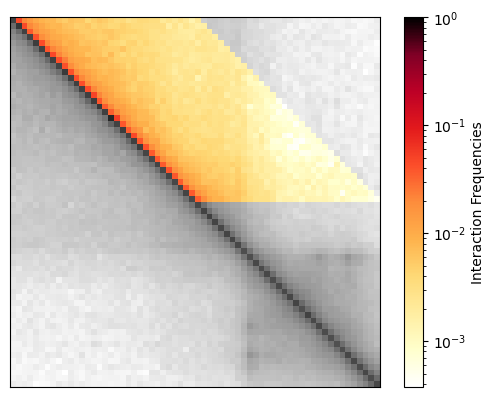

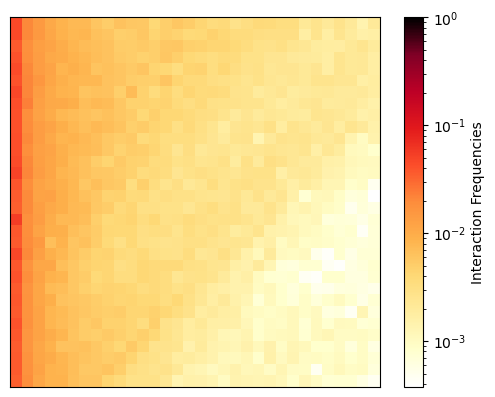

In [14]:
fig,ax,im,cbar = prob_map.plot(cmap='Greys')
cbar.remove()

sub_map = get_subregion(prob_map,keep_size=True)
sub_map.plot(fig=fig,ax=ax)

sub_map2 = get_subregion(prob_map)
sub_map2.plot()

'''
# Plot the region boundaries
ax.plot([1,33],[0,0]) # Top
ax.plot([33,65],[32,32]) # Bottom
ax.plot([1,33],[0,32]) # top left -> bottom left
ax.plot([33,65],[0,32]) # Top right -> bottom right
'''

'\n# Plot the region boundaries\nax.plot([1,33],[0,0]) # Top\nax.plot([33,65],[32,32]) # Bottom\nax.plot([1,33],[0,32]) # top left -> bottom left\nax.plot([33,65],[0,32]) # Top right -> bottom right\n'

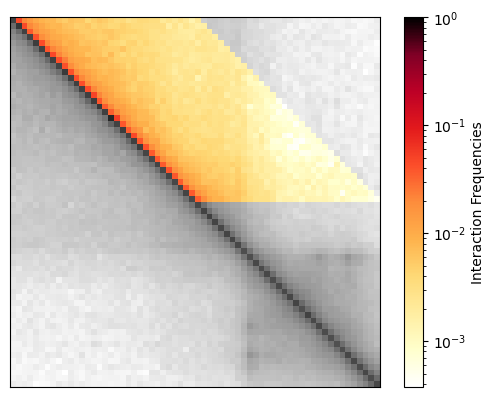

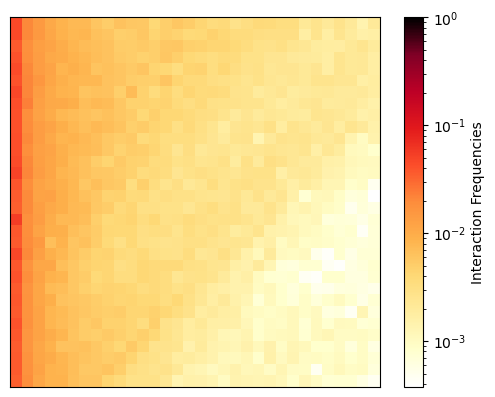

In [15]:
fig,ax,im,cbar = prob_map.plot(cmap='Greys')
cbar.remove()

sub_mapb = get_subregion(prob_map,keep_size=True)
sub_mapb.plot(fig=fig,ax=ax)

sub_map2b = get_subregion2(prob_map)
sub_map2b.plot()

'''
# Plot the region boundaries
ax.plot([1,33],[0,0]) # Top
ax.plot([33,65],[32,32]) # Bottom
ax.plot([1,33],[0,32]) # top left -> bottom left
ax.plot([33,65],[0,32]) # Top right -> bottom right
'''

In [17]:
(sub_map2b.prob_map == sub_map2.prob_map).all()

tensor(True)

In [22]:
compute_subregion = ComputeSubregion(prob_map.shape[-1])
sub_map2c = compute_subregion(prob_map)
(sub_map2c == sub_map2.prob_map).all()

tensor(True)

In [31]:
compute_subregion = ComputeSubregion(prob_map.shape[-1])
sub_map2d = compute_subregion(prob_map.prob_map.repeat(10,1,1))
[ (sub_map2d[i,...] == sub_map2.prob_map).all() for i in range(sub_map2d.shape[0])]

[tensor(True),
 tensor(True),
 tensor(True),
 tensor(True),
 tensor(True),
 tensor(True),
 tensor(True),
 tensor(True),
 tensor(True),
 tensor(True)]

In [32]:
int(True) 

1

In [33]:
int(False) 

0

In [8]:
from classifier_free_guidance_greg import * 

class EmbeddingEmbedder(nn.Module): 

    def __init__(
        self,
        dim,
        embedding_dimensions=(1,260,256),
        resnet_block_groups = 8,
        dim_mults=(1,.5,.25,.125)
    ):
        super().__init__()

        c,h,w = embedding_dimensions
        s = 256
        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        ############
        # Build the network 

        # Make the input square 
        # (1,260,256) -> 2x256x256
        self.make_square = nn.Sequential(
            nn.Conv2d(in_channels=c,out_channels=2*c,kernel_size=7,stride=1, padding=(1,3)), 
            nn.GELU()
        )
        c*= 2 # update # channels

        # Gradually increase the number of channels 
        # (2,256,256) -> (32,256,256)
        self.conv_layers = nn.Sequential()
        for i in range(4): #range(int(torch.log2(torch.tensor(dim/c/2)))):
            self.conv_layers.append(
                nn.Conv2d(c,2*c, 3, padding = 1)
            )
            if c*2 > 1: # number channels >= 16
                self.conv_layers.append(
                    nn.Dropout(p=.1)
                )
            c*=2

        init_dim = c
        dims = [init_dim, *map(lambda m: int(dim * m), dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        # Decrease the size of the input in sequential Resnet blocks
        self.downs = nn.ModuleList([])
        num_resolutions = len(in_out)
        
        # (8,256,256) -> (32,16,16) (if using (1,.5,.25,.125)
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)
            self.downs.append(nn.ModuleList([
                block_klass(dim_in, 2*dim_in),
                block_klass(2*dim_in, dim_in),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out)
            ]))

    '''
    @property 
    def device(self):
        return 
    '''
        
    def forward(self,x):
        x = self.make_square(x)
        x = self.conv_layers(x)
        for block1, block2, attn, downsample in self.downs:
            x = block1(x)
            x = block2(x)
            x = attn(x)
            x = downsample(x)
        
        return x 

In [20]:
from classifier_free_guidance_greg import * 
class EmbeddingEmbedder(nn.Module): 

    def __init__(
        self,
        dim,
        classes_dim,
        embedding_dimensions=(1,260,256),
        resnet_block_groups = 8,
        dim_mults=(1,2,1,.5)#(1,.5,.25,.125)
    ):
        super().__init__()

        c,h,w = embedding_dimensions
        s = 256
        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        ############
        # Build the network 

        # Make the input square 
        # (1,260,256) -> 2x256x256
        self.make_square = nn.Sequential(
            nn.Conv2d(in_channels=c,out_channels=2*c,kernel_size=7,stride=1, padding=(1,3)), 
            nn.GELU()
        )
        c*= 2 # update # channels

        # Gradually increase the number of channels 
        # (2,256,256) -> (32,256,256)
        self.conv_layers = nn.Sequential()
        for i in range(4): #range(int(torch.log2(torch.tensor(dim/c/2)))):
            self.conv_layers.append(
                nn.Conv2d(c,2*c, 3, padding = 1)
            )
            if c*2 > 1: # number channels >= 16
                self.conv_layers.append(
                    nn.Dropout(p=.1)
                )
            self.conv_layers.append(nn.GELU())
            c*=2

        init_dim = c
        dims = [init_dim, *map(lambda m: int(dim * m), dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        # Decrease the size of the input in sequential Resnet blocks
        self.downs = nn.ModuleList([])
        num_resolutions = len(in_out)
        
        # (8,256,256) -> (32,16,16) (if using (1,.5,.25,.125)
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)
            self.downs.append(nn.ModuleList([
                block_klass(dim_in, 2*dim_in),
                block_klass(2*dim_in, dim_in),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out)
            ]))

        self.linear_layer = nn.Sequential()
        self.linear_layer.append(Flatten())
        self.linear_layer.append( nn.Linear(32*16**2,classes_dim) )

    '''
    @property 
    def device(self):
        return 
    '''
        
    def forward(self,x):
        x = self.make_square(x)
        x = self.conv_layers(x)
        for block1, block2, attn, downsample in self.downs:
            x = block1(x)
            x = block2(x)
            x = attn(x)
            x = downsample(x)
        x = self.linear_layer(x)
        
        return x 

In [21]:
embedder = EmbeddingEmbedder(64,256)
#embedder = EmbeddingEmbedder(64,4*64).cuda()

In [22]:
a = torch.randn(5,1,260,256)
b = embedder(a) 
b.shape

torch.Size([5, 256])

In [ ]:
import time
def check_times(embedder,nsamples=64,ntrials=1000): 

    embedder.eval()
    with torch.no_grad():
        times = []
        for _ in range(ntrials):
            a = torch.randn(nsamples,1,260,256).cuda()
            t = time.time()
            b = embedder(a)
            t-= time.time()
            del a,b
            times.append(-t)
    return times
        
    

In [ ]:
import time
def check_times(embedder,nsamples=64,ntrials=1000): 

    times = []
    for _ in range(ntrials):
        embedder.zero_grad()
        a = torch.randn(nsamples,1,260,256).cuda()
        t = time.time()
        b = embedder(a)
        t-= time.time()
        del a,b
        times.append(-t)
    return times
        
times = check_times(embedder,nsamples=32,ntrials=10)

# Origami Transformation

In [74]:
import torch
class OrigamiTransform:

    #def __init__(self,nbeads,includes_self_interaction=False):
    '''
    Input size: (optional, batch etc)xCxHxW
    H == W, always

    Full map (Input to __call__, output of inverse): 
    C == 1
    H == nbeads if includes_self_interaction else nbeads-1 (diagonal removed in second case) 

    Condensed map (output of __call__, input to inverse): 
    C == 2
    H == nbeads//2 
    '''
        
    def __call__(self,full_map):
        '''
        Input size: (optional dims, batch, channels, etc)x(im_size 1 == full_map.shape[-1]//2 (nbeads-1))
        '''
        ####
        # Verify input 
        assert len(full_map.shape) > 1, f'full_maps must have at least 2 dimensions since OrigamiTransform processes 2D data.'
        assert full_map.shape[-2] == full_map.shape[-1], f'Final two dimensions of full_maps should be equal. Receieved {full_map.shape}'

        ####
        # Add dimension for channels if one wasn't provided
        if len(full_map.shape) == 2: 
            full_map = full_map.unsqueeze(0)
        if full_map.shape[-3] != 1: 
            full_map = full_map.unsqueeze(-3)

        ####
        # Perform the transformation. 

        # Infer useful information 
        shift = full_map.shape[-1] % 2 # Shift to account for self-interactions, if present 
        shift2 = full_map.shape[-1]//2 + shift # Starting position for further elements.
        n,optional_dims = full_map.shape[-1]//2, full_map.shape[:-3]
        i,j = torch.triu_indices(n,n,0)

        submap = torch.empty(*optional_dims,2,n,n,dtype=full_map.dtype,device=full_map.device)

        # Data folded under
        submap[...,1,i,j] = full_map[...,0,i,j+shift] # Top left of preserved portion of the full map, folded right
        submap[...,1,j,i] = full_map[...,0,i+shift2,j+shift+shift2] # Bottom right of preserved portion of the full map, folded up

        # Flip the last two dimensions so that the final result has the origami fold rather than shifted data
        submap = submap.flip([-1]) 

        # Top data
        submap[...,0,:,:] = full_map[...,0,:n,-n:]

        return submap

    def inverse(self,submap,diagonal_value=None):
        '''
        If diagonal_value is not None, then return the matrix with self interactions
        along the diagonal, value there determined by diagonal_value 
        '''
        assert len(submap.shape) > 2, f'Must have at least 3 dimensions in submap. Received {submap.shape}'
        assert submap.shape[-2]==submap.shape[-1], f'Last two dimensions of submap must be equal in size. Received {submap.shape}'
        assert submap.shape[-3]==2, f'Third-to-last dimension in submap should be size 2 (2 channels), but receieved {submap.shape[-3]}'

        # Useful info 
        n = submap.shape[-1]
        shift = int(diagonal_value is not None)
        shift2 = n + shift
        N = 2*n + shift
        optional_dims = submap.shape[:-3]

        # Initialize the full map 
        full_map = torch.zeros(*optional_dims,1,N,N,dtype=submap.dtype,device=submap.device)

        # Upper right quadrant
        full_map[...,0,:n,-n:] = submap[...,0,:,:]

        # Flip the submap's final two dimensions for easier indexing given the folding procedure
        submap = submap.flip([-1])

        # Fill in the triangular edge regions
        i,j = torch.triu_indices(n,n,0) 
        full_map[...,0,i,j+shift] = submap[...,1,i,j]
        full_map[...,0,i+shift2,j+shift+shift2] = submap[...,1,j,i]

        # Symmetrize the matrices
        full_map+= full_map.clone().transpose(-2,-1) 

        # Fill in the diagonal, if necessary: 
        if diagonal_value is not None: 
            i = torch.arange(N) 
            full_map[...,i,i].fill_(diagonal_value) 

        return full_map 

In [207]:
import torch
class OrigamiTransform:

    #def __init__(self,nbeads,includes_self_interaction=False):
    '''
    Input size: (optional, batch etc)xCxHxW
    H == W, always

    Full map (Input to __call__, output of inverse): 
    C == 1
    H == nbeads

    Condensed map (output of __call__, input to inverse): 
    C == 2
    H == nbeads//2 

    NOTE: The first half of the main diagonal is lost in the submap. Upon reconstruction, 
    the second half of the main diagonal is reflected to fill in the first half. As such, 
    the main diagonal must contain unimportant values to avoid issues; this is generally true 
    when speaking of self-interaction values, so it's ok for our purposes. 
    '''
        
    def __call__(self,full_map):
        '''
        Input size: (optional dims, batch, channels, etc)x(im_size 1 == full_map.shape[-1]//2 (nbeads-1))
        '''
        ####
        # Verify input 
        assert len(full_map.shape) > 1, f'full_maps must have at least 2 dimensions since OrigamiTransform processes 2D data.'
        assert full_map.shape[-2] == full_map.shape[-1], f'Final two dimensions of full_maps should be equal. Receieved {full_map.shape}'
        assert full_map.shape[-1]%2 == 0, f'OrigamiTransform only operates on maps with even dimensions. Received shape {full_map.shape}'

        ####
        # Add dimension for channels if one wasn't provided
        if len(full_map.shape) == 2: 
            full_map = full_map.unsqueeze(0)
        if full_map.shape[-3] != 1: 
            full_map = full_map.unsqueeze(-3)

        ####
        # Perform the transformation. 

        # Infer useful information 
        n = full_map.shape[-1]//2 # Starting position for further elements.
        optional_dims = full_map.shape[:-3]
        i,j = torch.triu_indices(n,n,0)

        submap = torch.empty(*optional_dims,2,n,n,dtype=full_map.dtype,device=full_map.device)

        # Data folded under        
        submap[...,1,i,j] = full_map[...,0,i,j] # Top left of preserved portion of the full map, folded right
        submap[...,1,j,i] = full_map[...,0,i+n,j+n] # Bottom right of preserved portion of the full map, folded up

        # Flip the last dimension so that the final arrangement resembles the triangular regions folding behind the square region
        submap = submap.flip([-1]) 

        # Top data
        submap[...,0,:,:] = full_map[...,0,:n,-n:]

        return submap

    def inverse(self,submap):
        assert len(submap.shape) > 2, f'Must have at least 3 dimensions in submap. Received {submap.shape}'
        assert submap.shape[-2]==submap.shape[-1], f'Last two dimensions of submap must be equal in size. Received {submap.shape}'
        assert submap.shape[-3]==2, f'Third-to-last dimension in submap should be size 2 (2 channels), but receieved {submap.shape[-3]}'

        # Useful info 
        n = submap.shape[-1]
        N = 2*n
        optional_dims = submap.shape[:-3]

        # Initialize the full map 
        full_map = torch.zeros(*optional_dims,1,N,N,dtype=submap.dtype,device=submap.device)

        # Upper right quadrant
        full_map[...,0,:n,-n:] = submap[...,0,:,:]

        # Flip the last dimension to simplify indexing when handling the folded regions
        submap = submap.flip([-1])

        # Fill in the triangular edge regions
        i,j = torch.triu_indices(n,n,0) 
        full_map[...,0,i,j] = submap[...,1,i,j]
        full_map[...,0,i+n,j+n] = submap[...,1,j,i]

        # Symmetrize the matrices
        full_map+= full_map.clone().transpose(-2,-1)

        # The diagonal was double during symmetrization, so divide it by 2
        i = torch.arange(N)
        full_map[...,i,i]/= 2
        
        return full_map 

In [264]:
import torch
class OrigamiTransform:

    #def __init__(self,nbeads,includes_self_interaction=False):
    '''
    Input size: (optional, batch etc)xCxHxW
    H == W, always

    Full map (Input to __call__, output of inverse): 
    C == 1
    H == nbeads

    Condensed map (output of __call__, input to inverse): 
    C == 2
    H == nbeads//2 

    NOTE: The first half of the main diagonal is lost in the submap. Upon reconstruction, 
    the second half of the main diagonal is reflected to fill in the first half. As such, 
    the main diagonal must contain unimportant values to avoid issues; this is generally true 
    when speaking of self-interaction values, so it's ok for our purposes. 
    '''
        
    def __call__(self,full_map):
        '''
        Input size: (optional dims, batch, channels, etc)x(im_size 1 == full_map.shape[-1]//2 (nbeads-1))
        '''
        ####
        # Verify input 
        assert len(full_map.shape) > 1, f'full_maps must have at least 2 dimensions since OrigamiTransform processes 2D data.'
        assert full_map.shape[-2] == full_map.shape[-1], f'Final two dimensions of full_maps should be equal. Receieved {full_map.shape}'
        assert full_map.shape[-1]%2 == 0, f'OrigamiTransform only operates on maps with even dimensions. Received shape {full_map.shape}'

        ####
        # Add dimension for channels if one wasn't provided
        if len(full_map.shape) == 2: 
            full_map = full_map.unsqueeze(0)
        if full_map.shape[-3] != 1: 
            full_map = full_map.unsqueeze(-3)

        ####
        # Perform the transformation. 

        # Infer useful information 
        n = full_map.shape[-1]//2 # Starting position for further elements.
        optional_dims = full_map.shape[:-3]
        i,j = torch.triu_indices(n,n,0)

        submap = torch.empty(*optional_dims,2,n,n,dtype=full_map.dtype,device=full_map.device)

        # Data folded under
        submap[...,1,i,j] = full_map[...,0,i,j] # Top left of preserved portion of the full map, folded right
        submap[...,1,j,i] = full_map.flip([-2,-1])[...,0,j,i]

        # Flip the last dimension so that the final arrangement resembles the triangular regions folding behind the square region
        submap = submap.flip([-1]) 

        # Top data
        submap[...,0,:,:] = full_map[...,0,:n,-n:]

        return submap

    def inverse(self,submap):
        assert len(submap.shape) > 2, f'Must have at least 3 dimensions in submap. Received {submap.shape}'
        assert submap.shape[-2]==submap.shape[-1], f'Last two dimensions of submap must be equal in size. Received {submap.shape}'
        assert submap.shape[-3]==2, f'Third-to-last dimension in submap should be size 2 (2 channels), but receieved {submap.shape[-3]}'

        # Useful info 
        n = submap.shape[-1]
        N = 2*n
        optional_dims = submap.shape[:-3]

        # Initialize the full map 
        full_map = torch.zeros(*optional_dims,1,N,N,dtype=submap.dtype,device=submap.device)

        # Upper right quadrant
        full_map[...,0,:n,-n:] = submap[...,0,:,:]

        # Flip the last dimension to simplify indexing when handling the folded regions
        submap = submap.flip([-1])

        # Fill in the triangular edge regions
        i,j = torch.triu_indices(n,n,0) 
        full_map[...,0,i,j] = submap[...,1,i,j]
        #full_map[...,0,i+n,j+n] = submap[...,1,j,i]
        full_map = full_map.flip([-2,-1])
        full_map[...,0,j,i] = submap[...,1,j,i]
        full_map = full_map.flip([-2,-1])

        # Symmetrize the matrices
        full_map+= full_map.clone().transpose(-2,-1)

        # The diagonal was double during symmetrization, so divide it by 2
        i = torch.arange(N)
        full_map[...,i,i]/= 2
        
        return full_map 

In [307]:
import torch

def transpose_minor_axis(tensor):
    return tensor.flip(-1).transpose(-2,-1).flip(-1)
    
class OrigamiTransform:

    #def __init__(self,nbeads,includes_self_interaction=False):
    '''
    Input size: (optional, batch etc)xCxHxW
    H == W, always

    Full map (Input to __call__, output of inverse): 
    C == 1
    H == nbeads

    Condensed map (output of __call__, input to inverse): 
    C == 2
    H == nbeads//2 

    NOTE: The first half of the main diagonal is lost in the submap. Upon reconstruction, 
    the second half of the main diagonal is reflected to fill in the first half. As such, 
    the main diagonal must contain unimportant values to avoid issues; this is generally true 
    when speaking of self-interaction values, so it's ok for our purposes. 
    '''
        
    def __call__(self,full_map):
        '''
        Input size: (optional dims, batch, channels, etc)x(im_size 1 == full_map.shape[-1]//2 (nbeads-1))
        '''
        ####
        # Verify input 
        assert len(full_map.shape) > 1, f'full_maps must have at least 2 dimensions since OrigamiTransform processes 2D data.'
        assert full_map.shape[-2] == full_map.shape[-1], f'Final two dimensions of full_maps should be equal. Receieved {full_map.shape}'
        assert full_map.shape[-1]%2 == 0, f'OrigamiTransform only operates on maps with even dimensions. Received shape {full_map.shape}'

        ####
        # Add dimension for channels if one wasn't provided
        if len(full_map.shape) == 2: 
            full_map = full_map.unsqueeze(0)
        if full_map.shape[-3] != 1: 
            full_map = full_map.unsqueeze(-3)

        ####
        # Perform the transformation. 

        # Infer useful information 
        n = full_map.shape[-1]//2 # Starting position for further elements.
        optional_dims = full_map.shape[:-3]
        i,j = torch.triu_indices(n,n,0)

        submap = torch.empty(*optional_dims,2,n,n,dtype=full_map.dtype,device=full_map.device)

        # Data folded under
        submap[...,1,i,j] = full_map[...,0,i,j] # Top left of preserved portion of the full map, folded right
        submap[...,1,j,i] = full_map.flip([-2,-1])[...,0,j,i]

        # Flip the last dimension so that the final arrangement resembles the triangular regions folding behind the square region
        submap = submap.flip([-1]) 

        # Top data
        submap[...,0,:,:] = full_map[...,0,:n,-n:]

        return submap

    def inverse(self,submap):
        assert len(submap.shape) > 2, f'Must have at least 3 dimensions in submap. Received {submap.shape}'
        assert submap.shape[-2]==submap.shape[-1], f'Last two dimensions of submap must be equal in size. Received {submap.shape}'
        assert submap.shape[-3]==2, f'Third-to-last dimension in submap should be size 2 (2 channels), but receieved {submap.shape[-3]}'

        # Useful info 
        n = submap.shape[-1]
        N = 2*n
        optional_dims = submap.shape[:-3]

        # Initialize the full map 
        full_map = torch.zeros(*optional_dims,1,N,N,dtype=submap.dtype,device=submap.device)

        # Flip the last dimension to simplify indexing when handling the folded regions
        submap = submap.flip([-1])

        # Fill in the triangular edge regions
        i,j = torch.triu_indices(n,n,0) 
        full_map[...,0,i,j] = submap[...,1,j,i] # Lower right portion
        full_map = transpose_minor_axis(full_map) # Place it in the lower right
        full_map[...,0,i,j] = submap[...,1,i,j]

        # Flip the last dimension back to its original position
        submap = submap.flip([-1])

        # Upper right quadrant
        full_map[...,0,:n,-n:] = submap[...,0,:,:]

        # Symmetrize the matrices
        full_map+= full_map.clone().transpose(-2,-1)

        # The diagonal was double during symmetrization, so divide it by 2
        i = torch.arange(N)
        full_map[...,i,i]/= 2
        
        return full_map 

In [323]:
import torch

def transpose_minor_axis(tensor):
    return tensor.flip(-1).transpose(-2,-1).flip(-1)
    
class OrigamiTransform:

    #def __init__(self,nbeads,includes_self_interaction=False):
    '''
    Input size: (optional, batch etc)xCxHxW
    H == W, always

    Full map (Input to __call__, output of inverse): 
    C == 1
    H == nbeads

    Condensed map (output of __call__, input to inverse): 
    C == 2
    H == nbeads//2 

    NOTE: The first half of the main diagonal is lost in the submap. Upon reconstruction, 
    the second half of the main diagonal is reflected to fill in the first half. As such, 
    the main diagonal must contain unimportant values to avoid issues; this is generally true 
    when speaking of self-interaction values, so it's ok for our purposes. 
    '''
        
    def __call__(self,full_map):
        '''
        Input size: (optional dims, batch, channels, etc)x(im_size 1 == full_map.shape[-1]//2 (nbeads-1))
        '''
        ####
        # Verify input 
        assert len(full_map.shape) > 1, f'full_maps must have at least 2 dimensions since OrigamiTransform processes 2D data.'
        assert full_map.shape[-2] == full_map.shape[-1], f'Final two dimensions of full_maps should be equal. Receieved {full_map.shape}'
        assert full_map.shape[-1]%2 == 0, f'OrigamiTransform only operates on maps with even dimensions. Received shape {full_map.shape}'

        ####
        # Add dimension for channels if one wasn't provided
        if len(full_map.shape) == 2: 
            full_map = full_map.unsqueeze(0)
        if full_map.shape[-3] != 1: 
            full_map = full_map.unsqueeze(-3)

        ####
        # Perform the transformation. 

        # Infer useful information 
        n = full_map.shape[-1]//2 # Starting position for further elements.
        optional_dims = full_map.shape[:-3]
        i,j = torch.triu_indices(n,n,0)

        submap = torch.empty(*optional_dims,2,n,n,dtype=full_map.dtype,device=full_map.device)

        # Data folded under
        submap[...,1,i,j] = full_map[...,0,i,j] # Top left of preserved portion of the full map, folded right
        #submap[...,1,j,i] = full_map.flip([-2,-1])[...,0,j,i] # Bottom of preserved portion, folded up
        submap[...,1,j,i] = transpose_minor_axis(full_map)[...,0,i,j] # Bottom of preserved portion, folded up

        # Flip the last dimension so that the final arrangement resembles the triangular regions folding behind the square region
        submap = submap.flip([-1]) 

        # Top data
        submap[...,0,:,:] = full_map[...,0,:n,-n:]

        return submap

    def inverse(self,submap):
        assert len(submap.shape) > 2, f'Must have at least 3 dimensions in submap. Received {submap.shape}'
        assert submap.shape[-2]==submap.shape[-1], f'Last two dimensions of submap must be equal in size. Received {submap.shape}'
        assert submap.shape[-3]==2, f'Third-to-last dimension in submap should be size 2 (2 channels), but receieved {submap.shape[-3]}'

        # Useful info 
        n = submap.shape[-1]
        N = 2*n
        optional_dims = submap.shape[:-3]

        # Initialize the full map 
        full_map = torch.zeros(*optional_dims,1,N,N,dtype=submap.dtype,device=submap.device)

        # Flip the last dimension to simplify indexing when handling the folded regions
        submap = submap.flip([-1])

        # Fill in the triangular edge regions
        i,j = torch.triu_indices(n,n,0) 
        full_map[...,0,i,j] = submap[...,1,j,i] # Lower right portion
        full_map = transpose_minor_axis(full_map) # Place it in the lower right
        full_map[...,0,i,j] = submap[...,1,i,j]

        # Flip the last dimension back to its original position
        submap = submap.flip([-1])

        # Upper right quadrant
        full_map[...,0,:n,-n:] = submap[...,0,:,:]

        # Symmetrize the matrices
        full_map+= full_map.clone().transpose(-2,-1)

        # The diagonal was double during symmetrization, so divide it by 2
        i = torch.arange(N)
        full_map[...,i,i]/= 2
        
        return full_map 

In [324]:
def generateSample(nbeads,nsamples=1,bond_length=1): 

    coords = torch.empty(nsamples,nbeads,3)
    coords[:,0,:] = 0 # Bead 0 at origin 
    for i in range(1,nbeads): 
        step = torch.randn(nsamples,3)
        step/= (step.square().sum(-1,keepdim=True).sqrt() * bond_length).expand(-1,3) 
        coords[:,i,:] = coords[:,i-1,:] + step

    return coords

In [325]:
sample = generateSample(64,10)
sample.shape

torch.Size([10, 64, 3])

In [326]:
dists = torch.cdist(sample,sample).unsqueeze(-3)
dists = (dists + dists.transpose(-2,-1))/2
dists.shape

torch.Size([10, 1, 64, 64])

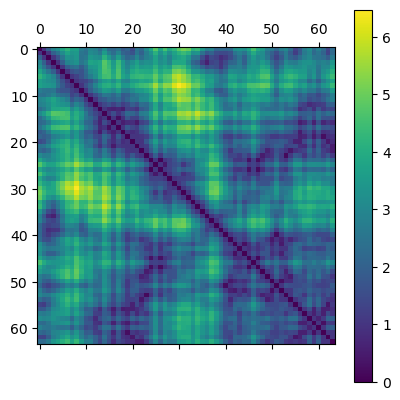

In [327]:
import matplotlib.pyplot as plt
plt.matshow(dists[3,0,:,:].cpu().numpy())
plt.colorbar()

In [328]:
origami_transform = OrigamiTransform()
submap = origami_transform(dists)
dists2 = origami_transform.inverse(submap) 

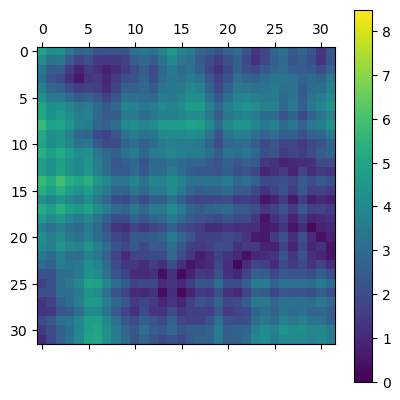

In [329]:
plt.matshow(submap[3,0,:,:].cpu().numpy(),vmin=0,vmax=8.5)
plt.colorbar()

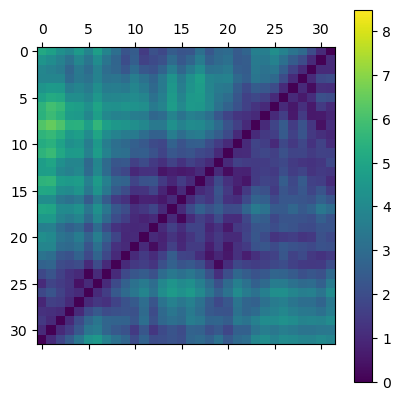

In [330]:
plt.matshow(submap[3,1,:,:].cpu().numpy(),vmin=0,vmax=8.5)
plt.colorbar()

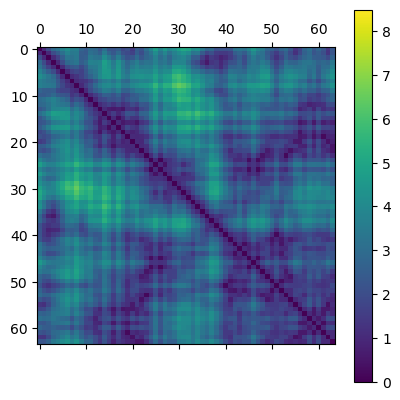

In [331]:
import matplotlib.pyplot as plt
plt.matshow(dists2[3,0,:,:].cpu().numpy(),vmin=0,vmax=8.5)
plt.colorbar()

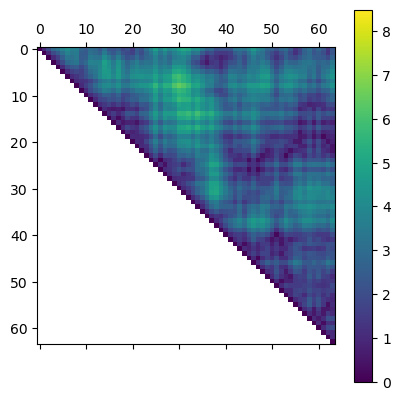

In [332]:
import matplotlib.pyplot as plt
temp = dists2[3,0,:,:].clone()
i,j = torch.triu_indices(temp.shape[-1],temp.shape[-1],1)
temp[j,i] = torch.nan
plt.matshow(temp.cpu().numpy(),vmin=0,vmax=8.5)
plt.colorbar()

#### Visualize the fold

In [333]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
n = 3
#i,j = torch.triu_indices(temp.shape[-1],temp.shape[-1],1)
#vmin = .75#dists2[n,0,i,j].min()
#vmax = dists2[n,0,i,j].max()
vmin=0
vmax=8.5

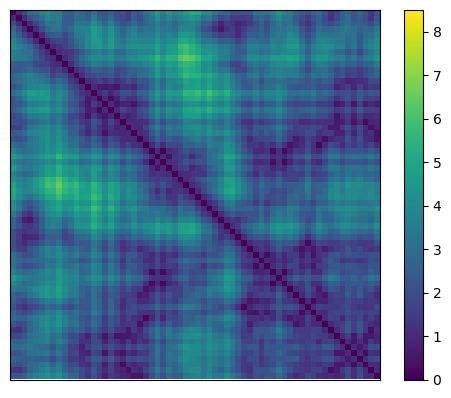

In [334]:
fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.matshow(dists2[n,0,:,:].cpu().numpy(),vmin=vmin,vmax=vmax)
fig.colorbar(im)
ax.set_xticks([])
ax.set_yticks([]);

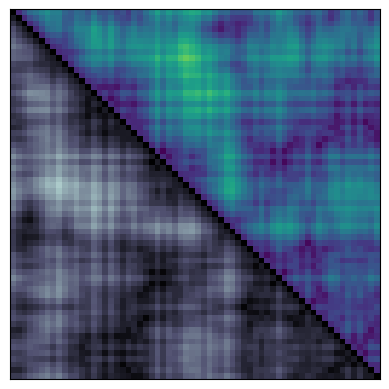

In [335]:
fig = plt.figure()
ax = fig.add_subplot(111)

temp = dists2[n,0,:,:].clone()
i,j = torch.triu_indices(temp.shape[-1],temp.shape[-1],1)
temp[i,j] = torch.nan

im = ax.matshow(dists2[n,0,:,:].cpu().numpy(),vmin=vmin,vmax=vmax)
im = ax.matshow(temp,cmap='bone',vmin=vmin,vmax=vmax)
#fig.colorbar(im)
ax.set_xticks([])
ax.set_yticks([]);

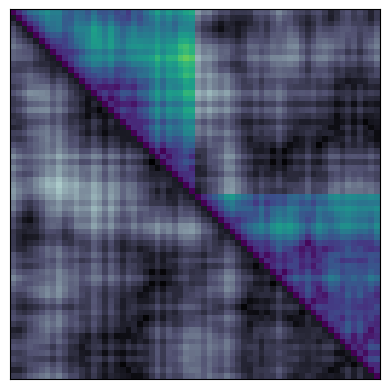

In [336]:
fig = plt.figure()
ax = fig.add_subplot(111)

temp = dists2[n,0,:,:].clone()
i,j = torch.triu_indices(temp.shape[-1],temp.shape[-1],1)
temp[j,i] = torch.nan
nn = temp.shape[-1]//2
temp[:nn,-nn:] = torch.nan

im = ax.matshow(dists2[n,0,:,:].cpu().numpy(),cmap='bone',vmin=vmin,vmax=vmax)
im = ax.matshow(temp,vmin=vmin,vmax=vmax)
#fig.colorbar(im)
ax.set_xticks([])
ax.set_yticks([]);

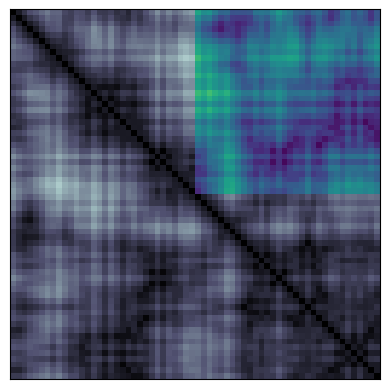

In [337]:
fig = plt.figure()
ax = fig.add_subplot(111)

temp = torch.empty_like(dists2[n,0,:,:]).fill_(torch.nan)
temp[:nn,-nn:] = dists2[n,0,:nn,-nn:]

im = ax.matshow(dists2[n,0,:,:].cpu().numpy(),cmap='bone',vmin=vmin,vmax=vmax)
im = ax.matshow(temp,vmin=vmin,vmax=vmax)
#fig.colorbar(im)
ax.set_xticks([])
ax.set_yticks([]);

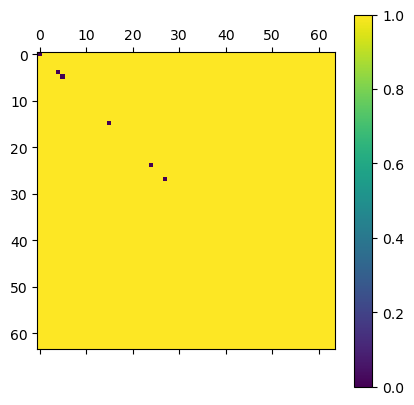

In [338]:
plt.matshow((dists[0,0,...]==dists2[0,0,...]).numpy())
plt.colorbar()